# Yelp Reviews on Portland's Cafés | Classification

In [101]:
# munging imports
import pandas as pd
import numpy as np
from copy import copy, deepcopy
pd.options.mode.chained_assignment = None

# visualization imports
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, datasets
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy import stats
from sklearn.inspection import permutation_importance
from sklearn.utils import class_weight

In [55]:
# import from pickle
doc_topic = pd.read_pickle('doc_topic_cafes_portland.pickle')
reviews_full = pd.read_pickle('reviews_portland_full.pickle')

In [56]:
doc_topic.shape

(116437, 14)

In [57]:
doc_topic.head()

,text,savoury_food,doughnuts,coffee/barista,tea,ice_cream,books,location/atmosphere,service,pastries/desserts,review_id,business_id,stars,sentiment
0,dont bother going to voodoo just come here in...,0.00593,0.00539,0.00264,0.01943,0.00137,0.00027,0.00000,0.00213,0.00252,m-9DK7NwYedIPj1RQ_sXdw,H_RM2u1WWGU1HkKZrYq2Ow,5.0,positive
1,incredible donuts sometimes you have to go ea...,0.00000,0.09791,0.00000,0.00000,0.00000,0.00204,0.00261,0.00000,0.00000,lJ7rzbvT-l8KO8lHfEsXsg,H_RM2u1WWGU1HkKZrYq2Ow,5.0,positive
2,even the mad captain ahab is touched by starb...,0.00000,0.00002,0.00348,0.00088,0.00000,0.00160,0.01579,0.01538,0.00017,oL2y3mXe_qab349DPW6uZg,0nMbLN0B5I-2tNnQLSo86w,5.0,positive
3,it s crazy how establishments on the west coas...,0.02761,0.00224,0.00000,0.00203,0.00000,0.00000,0.00000,0.01834,0.00000,OH9E5SaGBQsPX3IktM30mg,Un6u2cECyV4nZb_HGZ-uTA,4.0,positive
4,stars for the location it s absolutely wond...,0.00000,0.00644,0.00000,0.00000,0.07397,0.00000,0.00097,0.01253,0.00000,drj-5euhU_5uVFcZ9nvsjw,g4CP3kgH1jTtMn-joxPT0A,4.0,positive


In [58]:
reviews_full.shape

(116437, 17)

In [59]:
reviews_full.head()

,text,savoury_food,doughnuts,coffee/barista,tea,ice_cream,books,location/atmosphere,service,pastries/desserts,review_id,business_id,stars,sentiment,name,latitude,longitude
0,dont bother going to voodoo just come here in...,0.00593,0.00539,0.00264,0.01943,0.00137,0.00027,0.00000,0.00213,0.00252,m-9DK7NwYedIPj1RQ_sXdw,H_RM2u1WWGU1HkKZrYq2Ow,5.0,positive,Blue Star Donuts,45.520717,-122.683874
1,incredible donuts sometimes you have to go ea...,0.00000,0.09791,0.00000,0.00000,0.00000,0.00204,0.00261,0.00000,0.00000,lJ7rzbvT-l8KO8lHfEsXsg,H_RM2u1WWGU1HkKZrYq2Ow,5.0,positive,Blue Star Donuts,45.520717,-122.683874
2,even the mad captain ahab is touched by starb...,0.00000,0.00002,0.00348,0.00088,0.00000,0.00160,0.01579,0.01538,0.00017,oL2y3mXe_qab349DPW6uZg,0nMbLN0B5I-2tNnQLSo86w,5.0,positive,Starbucks,45.533837,-122.537340
3,it s crazy how establishments on the west coas...,0.02761,0.00224,0.00000,0.00203,0.00000,0.00000,0.00000,0.01834,0.00000,OH9E5SaGBQsPX3IktM30mg,Un6u2cECyV4nZb_HGZ-uTA,4.0,positive,Tin Shed Garden Cafe,45.558987,-122.650876
4,stars for the location it s absolutely wond...,0.00000,0.00644,0.00000,0.00000,0.07397,0.00000,0.00097,0.01253,0.00000,drj-5euhU_5uVFcZ9nvsjw,g4CP3kgH1jTtMn-joxPT0A,4.0,positive,Tea Chai Te,45.465944,-122.653182


## Topic Size Analysis

For generalization and interpretability purposes, I want to first understand the impact that each topic has in determining sentiments. I will assign every review to a topic based on the highest coefficient for that review in the H matrix. Then, I will sum the columns corresponding to every single topic and gather a general undestanding of topic importance. 

In [60]:
reviews_topic_importance = reviews_full.iloc[:,:10].copy()

In [61]:
reviews_topic_importance.head()

,text,savoury_food,doughnuts,coffee/barista,tea,ice_cream,books,location/atmosphere,service,pastries/desserts
0,dont bother going to voodoo just come here in...,0.00593,0.00539,0.00264,0.01943,0.00137,0.00027,0.00000,0.00213,0.00252
1,incredible donuts sometimes you have to go ea...,0.00000,0.09791,0.00000,0.00000,0.00000,0.00204,0.00261,0.00000,0.00000
2,even the mad captain ahab is touched by starb...,0.00000,0.00002,0.00348,0.00088,0.00000,0.00160,0.01579,0.01538,0.00017
3,it s crazy how establishments on the west coas...,0.02761,0.00224,0.00000,0.00203,0.00000,0.00000,0.00000,0.01834,0.00000
4,stars for the location it s absolutely wond...,0.00000,0.00644,0.00000,0.00000,0.07397,0.00000,0.00097,0.01253,0.00000


In [62]:
# change dtypes to numeric
reviews_topic_importance[['savoury_food','doughnuts','coffee/barista','tea','ice_cream','books','location/atmosphere','service','pastries/desserts']] = \
reviews_topic_importance[['savoury_food','doughnuts','coffee/barista','tea','ice_cream','books','location/atmosphere','service','pastries/desserts']].apply(pd.to_numeric)

In [63]:
reviews_topic_importance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116437 entries, 0 to 116436
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   text                 116437 non-null  object 
 1   savoury_food         116437 non-null  float64
 2   doughnuts            116437 non-null  float64
 3   coffee/barista       116437 non-null  float64
 4   tea                  116437 non-null  float64
 5   ice_cream            116437 non-null  float64
 6   books                116437 non-null  float64
 7   location/atmosphere  116437 non-null  float64
 8   service              116437 non-null  float64
 9   pastries/desserts    116437 non-null  float64
dtypes: float64(9), object(1)
memory usage: 9.8+ MB


In [64]:
# find the max topic by row (review)
reviews_topic_importance['main_topic'] = reviews_topic_importance.iloc[:,1:].idxmax(axis=1)

In [65]:
reviews_topic_importance.head()

,text,savoury_food,doughnuts,coffee/barista,tea,ice_cream,books,location/atmosphere,service,pastries/desserts,main_topic
0,dont bother going to voodoo just come here in...,0.00593,0.00539,0.00264,0.01943,0.00137,0.00027,0.00000,0.00213,0.00252,tea
1,incredible donuts sometimes you have to go ea...,0.00000,0.09791,0.00000,0.00000,0.00000,0.00204,0.00261,0.00000,0.00000,doughnuts
2,even the mad captain ahab is touched by starb...,0.00000,0.00002,0.00348,0.00088,0.00000,0.00160,0.01579,0.01538,0.00017,location/atmosphere
3,it s crazy how establishments on the west coas...,0.02761,0.00224,0.00000,0.00203,0.00000,0.00000,0.00000,0.01834,0.00000,savoury_food
4,stars for the location it s absolutely wond...,0.00000,0.00644,0.00000,0.00000,0.07397,0.00000,0.00097,0.01253,0.00000,ice_cream


In [66]:
# drop topic columns before conducting one-hot encoding
reviews_topic_importance = reviews_topic_importance[['text','main_topic']]

In [67]:
reviews_topic_importance.head()

,text,main_topic
0,dont bother going to voodoo just come here in...,tea
1,incredible donuts sometimes you have to go ea...,doughnuts
2,even the mad captain ahab is touched by starb...,location/atmosphere
3,it s crazy how establishments on the west coas...,savoury_food
4,stars for the location it s absolutely wond...,ice_cream


In [68]:
# one-hot encode

# temporary df corresponding to one hot encoded col main_topic
temp_df = pd.get_dummies(reviews_topic_importance['main_topic'])

# merge into original df
reviews_topic_importance = pd.merge(left=reviews_topic_importance,
                                    right=temp_df,
                                    left_index=True,
                                    right_index=True)

In [69]:
reviews_topic_importance.head()

,text,main_topic,books,coffee/barista,doughnuts,ice_cream,location/atmosphere,pastries/desserts,savoury_food,service,tea
0,dont bother going to voodoo just come here in...,tea,0,0,0,0,0,0,0,0,1
1,incredible donuts sometimes you have to go ea...,doughnuts,0,0,1,0,0,0,0,0,0
2,even the mad captain ahab is touched by starb...,location/atmosphere,0,0,0,0,1,0,0,0,0
3,it s crazy how establishments on the west coas...,savoury_food,0,0,0,0,0,0,1,0,0
4,stars for the location it s absolutely wond...,ice_cream,0,0,0,1,0,0,0,0,0


In [70]:
# drop main_topic col
reviews_topic_importance.drop(['text','main_topic'],axis=1,inplace=True)
reviews_topic_importance.head()

,books,coffee/barista,doughnuts,ice_cream,location/atmosphere,pastries/desserts,savoury_food,service,tea
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0


In [71]:
count_positives = pd.DataFrame(reviews_topic_importance.sum(axis=0),columns=['count_positive_sentiment'])
count_positives.sort_values(['count_positive_sentiment'],ascending=False)

,count_positive_sentiment
service,35078
coffee/barista,20767
location/atmosphere,13123
savoury_food,11885
pastries/desserts,8894
doughnuts,7714
ice_cream,7238
tea,6695
books,5043


----

By assigning every document to the topic with the highest strength in the H matrix, it turns out that **service, coffee/barista and location/atmosphere** are the topics with the greatest weight across all documents (coffee reviews in Portland). Intuitively and from a user-cerntric perspective, this result definitely make sense.

----

## Classification Model

### 1. Choice of Classification evaluation metric

For the purpose of this classification model:
- $X$ will be composed of the 9 topics identified in the unsupervised learning model
- $Y$ corresponds to the variable *sentiment*, which can be positive (stars > 3) or negative (stars < 3)
- Topic strengths per document (as presented in the H matrix resulting from NMF) will be fed into the classification model

----

Since **interpretability** is the main objective here, and I am mostly interested in reaching a balance between precision and recall, the classification evaluation **metric of choice will be F1**. 

----

### 2. EDA

positive    0.85788
negative    0.14212
Name: sentiment, dtype: float64


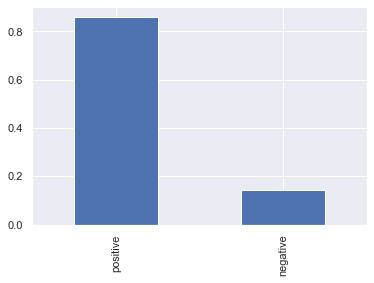

In [72]:
target_ = reviews_full['sentiment'].value_counts(normalize=True) 
print(target_)

target_.plot(kind='bar');

There is a heavy class imbalance towards the positive class. Hence, we will need to rebalance the classes as part of our classification algorithm.

<Figure size 432x288 with 0 Axes>

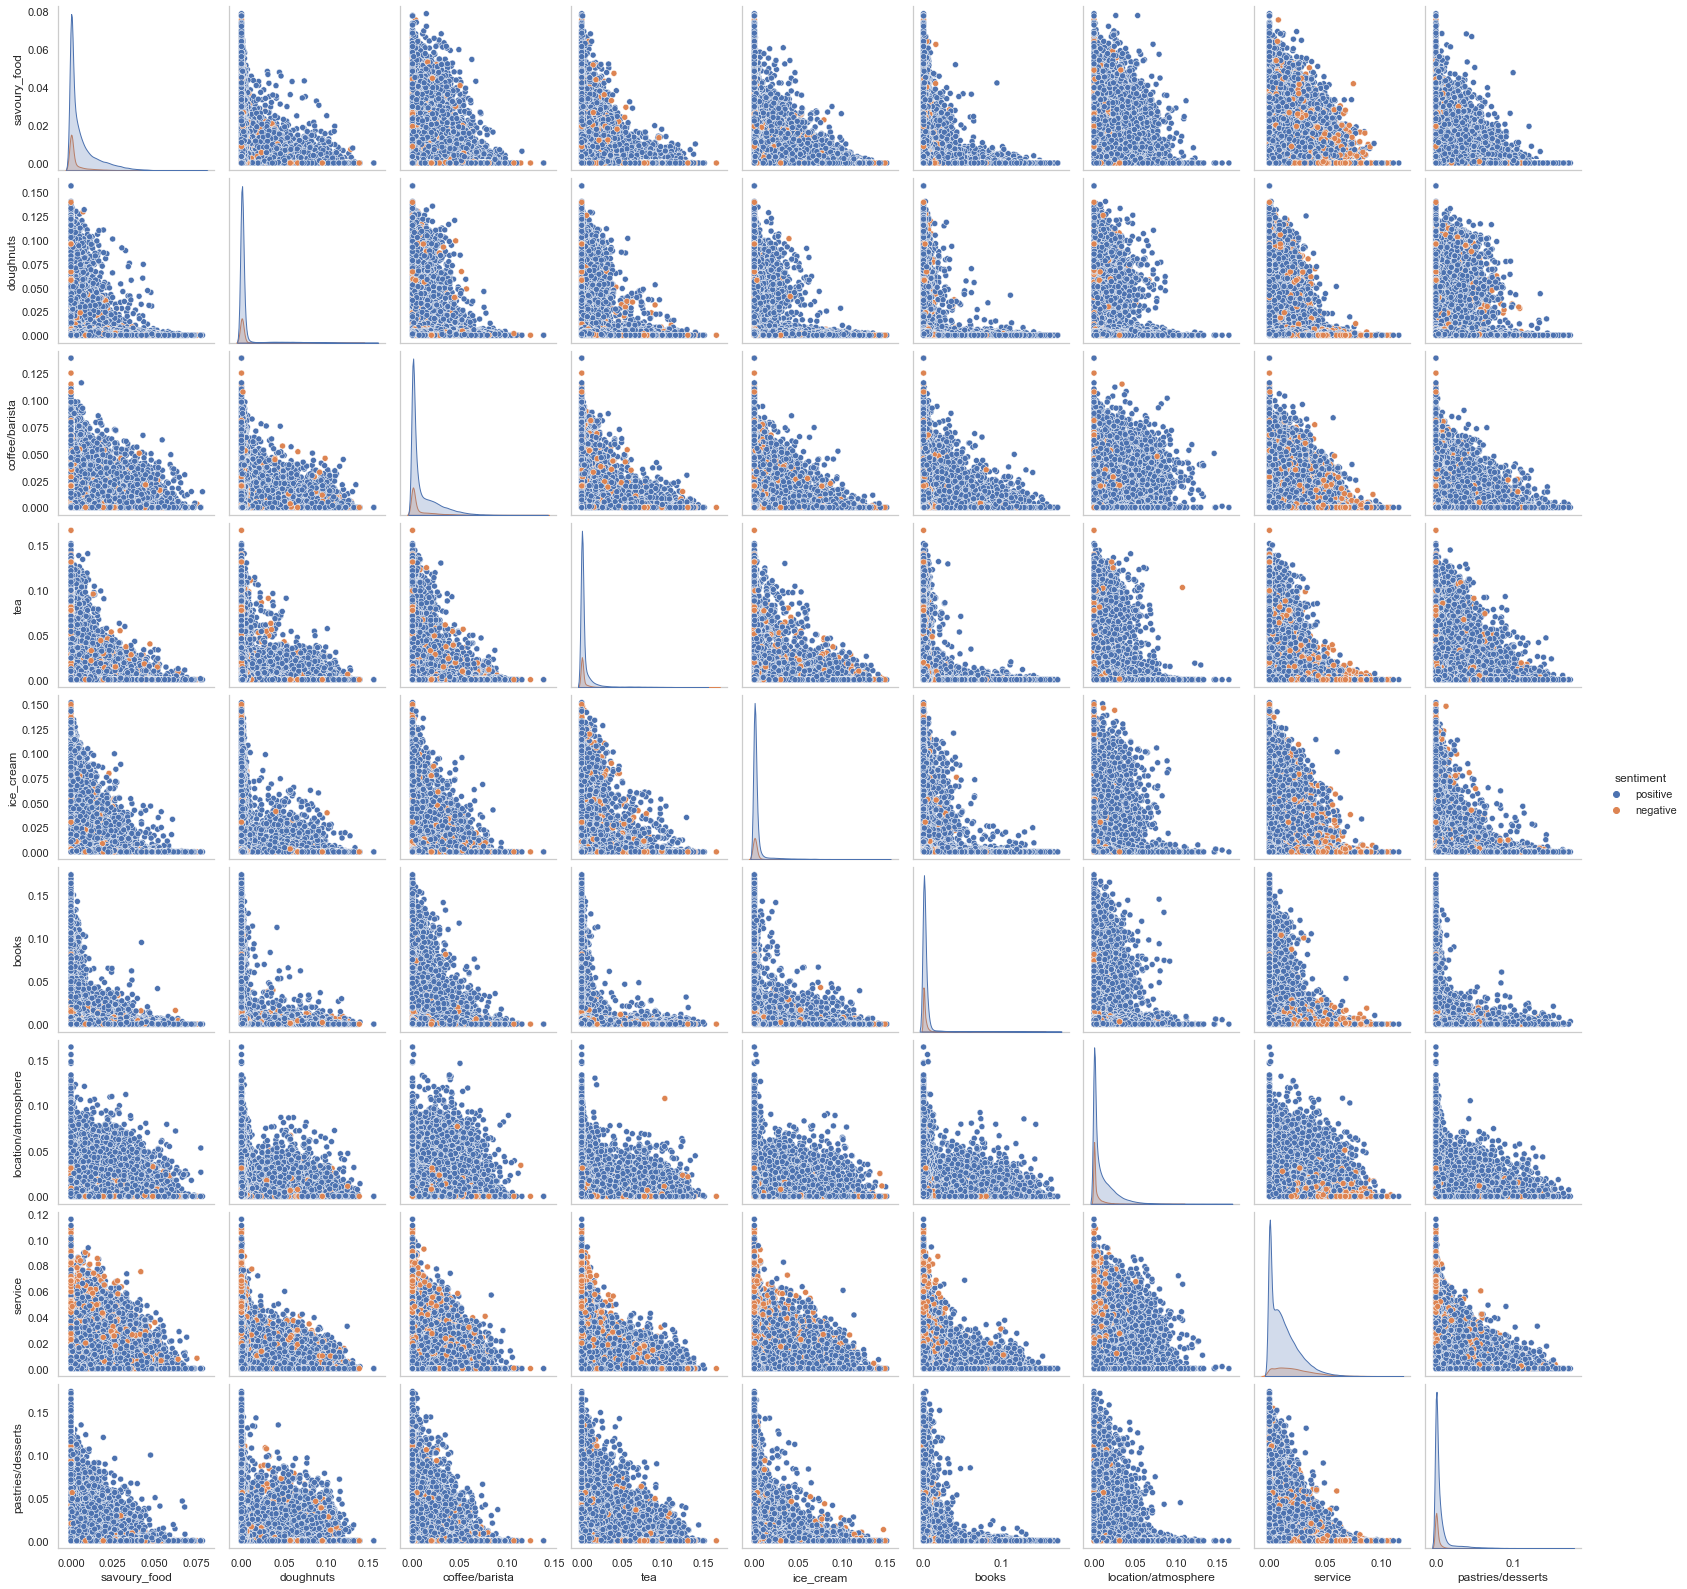

In [73]:
# pairplot
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure()
cols_to_plot = reviews_full.columns[1:10].tolist() + ['sentiment'] # explicitly add the column "sentiment"
sns.pairplot(reviews_full[cols_to_plot], hue ='sentiment')
plt.show();

> Even tho we cannot make the same deterministic observations as if we had actual features (and non topics) characterizing the observations, we can still see some separability in most of the topics presented above. <br/>
It's important to note that this plot is presented primarily for illustrative purposes; **topics do not have the same validity as features** (most commonly present in classification models) in describing the data. However, topics and their importance can be interpreted in relative terms versus each other and their general impact on sentiment can be derived from such a classification model. 

### 3. Baseline | Logistic Regression

In [74]:
baseline_features = reviews_full[['savoury_food', 'doughnuts','coffee/barista','tea','ice_cream','books','location/atmosphere','service','pastries/desserts']]
target = reviews_full['sentiment']

In [75]:
# run logistic regression as baseline

# define scaler
scaler = StandardScaler()

# split data
X_train, X_test, y_train, y_test = train_test_split(baseline_features, target, test_size = 0.2, random_state=42)

# scale data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# logistic regression -- define and fit model on training data
lr_baseline = LogisticRegression(C=1,class_weight='balanced') # need to rebalance positive and negative sentiment classes
lr_baseline.fit(X_train_scaled, y_train)

# logistic regression -- compute prediction on testing data
lr_y_pred = lr_baseline.predict(X_test_scaled)

# logistic regression -- score model based on standard accuracy metric and f1 beta score (metric to optimize for in my model) 
lr_accuracy_baseline = lr_baseline.score(X_test_scaled, y_test)
lr_fscore_baseline = f1_score(y_test, lr_y_pred, pos_label = 'positive') # indicate positive class as positive

print('\nLogReg | Baseline Test Accuracy score: \t', '{0:.4g}'.format(lr_accuracy_baseline))
print('LogReg | Baseline Test F1 score: \t', '{0:.4g}'.format(lr_fscore_baseline))


LogReg | Baseline Test Accuracy score: 	 0.6769
LogReg | Baseline Test F1 score: 	 0.7792


> Our baseline F1 score is already pretty good, confirming a good selection of topic for the sentiment classification modeling.

In [76]:
# print coefficients
log_odds = lr_baseline.coef_[0]
pd.DataFrame(log_odds, 
             baseline_features.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
location/atmosphere,1.149756
books,0.585834
savoury_food,0.568565
pastries/desserts,0.376544
tea,0.276107
coffee/barista,0.259278
doughnuts,0.209558
ice_cream,0.143564
service,-0.322367


> Interestingly, in this first model iteration, we notice that ***location/atmosphere*** has a larger impact on driving positive sentiment than *savoury_food* or even *coffee/barista*. Especially in this new wave of hipster and trendy cafes, location and decor matter so much. The main food categories that we would expect to find at a cafe (i.e. *savoury food* and *pastries/desserts*) seem to also have a greater impact in driving positive sentiment reviews.<br/>

>***Coffee/barista*** which technically represent the core of cafes' offerings, lies in the middle of our ranked list of coefficients. This is probably due to the fact that, in the customer's mindset, having a good coffee at a cafe is a given, especially in a city like Portland where the quality of coffee is so much higher than the national average. Therefore, the customer will consider location, food and other elements as more important than coffee in driving positive sentiment towards a specific cafe: ultimately these other elements will have comparatively a greater impact in differentiating a cafe from another one in Portland.<br/>

>***Service*** is presented as having a negative impact on generating positive sentiment reviews. However, in notebook *2_yelp_unsupervised_modeling*, we showed how there were 3 of the 9 topics characterizing negative sentiment reviews were about *service*. So, it could be very possible that, because of the predominance of service-related topics for negative vs positive sentiment reviews, what is described as *service* is actually *poor service*. To understand if this is true, I would need to run a CorEx and adopt a more granular approach to the *service* topic. For now I will keep the topic name as is and consider CorEx as a possible future development of this project.

### 4. Expanding the model

In [77]:
reviews_full['sentiment'].value_counts()

positive    99889
negative    16548
Name: sentiment, dtype: int64

In [78]:
sentiment_count = reviews_full.groupby(by=["sentiment"]).count()

In [79]:
# as suggested by the xgboost documentation, to address class imbalance, we will add a hyperparameter scale_pos_weight which will take the value below
scale_pos_xgboost = sentiment_count.iloc[0,0] / sentiment_count.iloc[1,0] # negative instances/positive instances

In [80]:
scale_pos_xgboost

0.16566388691447506

In [81]:
# replace sentiment values for modeling
reviews_full.replace({'sentiment' : { 'positive' : 1, 'negative' : 0}},inplace=True)

In [82]:
reviews_full['sentiment'].value_counts()

1    99889
0    16548
Name: sentiment, dtype: int64

> In a cross-validation scheme, I will compare two versions of the logistic regression (one without the topic *service* which had a negative coefficient in the baseline logistic regression), one random forest, one xgboost and one naive bayes. <br/>

> As we mentioned before, **interpretation is the main objective**. However, we cannot interpret logistic regression coefficients for topics (derived from NMF) as we would do with features; this is because we are feeding the classification model with topic strengths (from the H matrix) and not with actual numerical features characterizing the data. Therefore, given the lack of absolute interpretation power of a logistic regression coefficients, I will be open to considering other models like random forest and xgboost and consider feature importance for interpretation purposes.

In [83]:
features_lr1 = reviews_full[['savoury_food', 'doughnuts','coffee/barista','tea','ice_cream','books','location/atmosphere','pastries/desserts']] # eliminate service which had negative coefficient in baseline
features = reviews_full[['savoury_food', 'doughnuts','coffee/barista','tea','ice_cream','books','location/atmosphere','service','pastries/desserts']]
target = reviews_full['sentiment']

In [105]:
kf = KFold(n_splits=5, shuffle=True, random_state = 42) 
model_list = ['lr1','lr2','rf','xgb','nb']
validation_lr1 = []
validation_lr2 = []
validation_rf = []
validation_xgb = []
validation_nb = []

In [106]:
%%time
# split data into 3: 60% train, 20% validation, 20% test

for current_model in model_list:
    
    # initiate scaler
    scaler = StandardScaler()
    
    if current_model == 'lr1':
        
        # select features and target
        X = features_lr1
        y = target
    
    else:
        
        # select features and target
        X = features
        y = target
    
    # hold out 20% of the data for final testing
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    
    # create arrays for indexing
    X, y = np.array(X), np.array(y)    
    
    for train_ind, val_ind in kf.split(X,y):
        
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]
        
        # scale data for logistic regression models
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        if current_model == 'lr1':
            
            # lr1 -- define and fit model on training data
            lr1 = LogisticRegression(C=1,class_weight='balanced',random_state=42) # address imbalanced classes
            lr1.fit(X_train_scaled, y_train)

            # lr1 -- compute prediction on testing data
            lr1_y_pred = lr1.predict(X_val_scaled)

            # lr1 -- compute F1beta
            lr1_f1 = f1_score(y_val, lr1_y_pred) 

            # append validation result to list
            validation_lr1.append(float('{0:.4g}'.format(lr1_f1)))

        elif current_model == 'lr2':

            # lr2 -- define and fit model on training data
            lr2 = LogisticRegression(C=1,class_weight='balanced',random_state=42) # address imbalanced classes
            lr2.fit(X_train_scaled, y_train)

            # lr1 -- compute prediction on testing data
            lr2_y_pred = lr2.predict(X_val_scaled)

            # lr1 -- compute F1beta
            lr2_f1 = f1_score(y_val, lr2_y_pred) 

            # append validation result to list
            validation_lr2.append(float('{0:.4g}'.format(lr2_f1)))

        elif current_model == 'rf':

            # initiate RF classifier and fit the model on training data
            rf_cl = RandomForestClassifier(n_estimators=100, criterion = 'gini', bootstrap=True, n_jobs = -1, random_state=42, max_features='sqrt',class_weight='balanced') # address imbalanced classes
            rf_cl.fit(X_train, y_train)

            # prediction on test data
            rf_y_pred = rf_cl.predict(X_val)

            # random forest -- compute F1beta
            rf_f1 = f1_score(y_val, rf_y_pred)

            # append validation result to list
            validation_rf.append(float('{0:.4g}'.format(rf_f1)))

        elif current_model == 'xgb':

            # initiate the classifier
            xgb_cl = xgb.XGBClassifier(n_estimators=30000,
                                       max_depth=8,
                                       objective='binary:logistic',
                                       learning_rate=.05, 
                                       subsample=.8,
                                       min_child_weight=3,
                                       colsample_bytree=.8,
                                       n_jobs = -1,
                                       random_state=42,
                                       use_label_encoder = False,
                                       scale_pos_weight = scale_pos_xgboost)

            # establish evaluation set
            eval_set=[(X_train,y_train),(X_val,y_val)]

            # fit model
            fit_model = xgb_cl.fit(X_train, y_train, 
                                   eval_set=eval_set,  
                                   early_stopping_rounds=50,
                                   verbose=False,
                                   eval_metric='error')

            # compute preds
            xgb_preds = xgb_cl.predict(X_val, ntree_limit=xgb_cl.best_ntree_limit)

            # compute metric of interest
            xgb_f1 = f1_score(y_val, xgb_preds)

            # append validation result to list
            validation_xgb.append(float('{0:.4g}'.format(xgb_f1)))
            
        else:
            
            # create sample weight to balance for imbalanced classes
            sw = class_weight.compute_sample_weight('balanced', y_train)
            
            # nb -- define and fit model on training data
            nb = BernoulliNB()
            nb.fit(X_train, y_train, sample_weight=[sw[i] for i in y_train]) # correct class imbalance
            
            # nb -- compute prediction on testing data
            nb_y_pred = nb.predict(X_val_scaled)

            # nb -- compute F1beta
            nb_f1 = f1_score(y_val, nb_y_pred) 

            # append validation result to list
            validation_nb.append(float('{0:.4g}'.format(nb_f1)))
            

print(f'Logistic Regression #1 | Validation F1 score: \t{validation_lr1} | Average = {round(sum(validation_lr1) / len(validation_lr1),4)} \n')
print(f'Logistic Regression #2 | Validation F1 score: \t{validation_lr2} | Average = {round(sum(validation_lr2) / len(validation_lr2),4)} \n')
print(f'Random Forest | Validation F1 score: \t{validation_rf} | Average = {round(sum(validation_rf) / len(validation_rf),4)} \n')
print(f'XGBoosting | Validation F1 score: \t{validation_xgb} | Average = {round(sum(validation_xgb) / len(validation_xgb),4)} \n')
print(f'Naive Bayes | Validation F1 score: \t{validation_nb} | Average = {round(sum(validation_nb) / len(validation_nb),4)} \n')

Logistic Regression #1 | Validation F1 score: 	[0.7685, 0.7659, 0.7612, 0.7703, 0.7608] | Average = 0.7653 

Logistic Regression #2 | Validation F1 score: 	[0.7816, 0.7789, 0.7775, 0.7807, 0.7757] | Average = 0.7789 

Random Forest | Validation F1 score: 	[0.9268, 0.9251, 0.9258, 0.9256, 0.9263] | Average = 0.9259 

XGBoosting | Validation F1 score: 	[0.8725, 0.8668, 0.8677, 0.8754, 0.8536] | Average = 0.8672 

Naive Bayes | Validation F1 score: 	[0.8917, 0.891, 0.888, 0.891, 0.8915] | Average = 0.8906 

CPU times: user 28min 49s, sys: 42.7 s, total: 29min 31s
Wall time: 2min 47s


----

**Random forest** offers the best result in terms of F1 score. I will choose this one as the model of choice. For the purpose of this project, I am satisfied with a **F1 score of 0.93** and will not tune the random forest hyperparameters at this stage.

----

### 5. Final Scoring

In [111]:
%%time
# define X and Y
X = features
y = target

# hold out 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42,stratify=y)  


# initiate RF classifier and fit the model on training data
rf_cl = RandomForestClassifier(n_estimators=100, criterion = 'gini', bootstrap=True, n_jobs = -1, random_state=42, max_features='sqrt',class_weight='balanced') # address imbalanced classes
rf_cl.fit(X_train, y_train)

# prediction on test data
rf_y_pred = rf_cl.predict(X_test)

# score model on test set (final model score)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred) 
rf_recall = recall_score(y_test, rf_y_pred)
rf_accuracy = accuracy_score(y_test, rf_y_pred) 

# print results
print(f'Random Forest | Test F1 score: \t{rf_f1}\n')
print(f'Random Forest | Test Precision: {rf_precision}\n')
print(f'Random Forest | Test Recall: \t{rf_recall}\n')
print(f'Random Forest | Test Accuracy: \t{rf_accuracy}\n')

Random Forest | Test F1 score: 	0.9263816874148766

Random Forest | Test Precision: 0.8862524573675308

Random Forest | Test Recall: 	0.9703173490839924

Random Forest | Test Accuracy: 	0.8677001030573686

CPU times: user 25.6 s, sys: 541 ms, total: 26.1 s
Wall time: 2.84 s


## Visualizations

### 1. Confusion Matrix

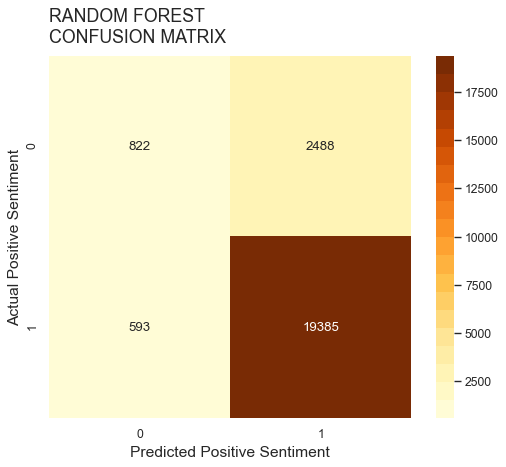

In [112]:
# Confusion Matrix

rf_confusion = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(8, 6), dpi=80)
color = sns.color_palette("YlOrBr",n_colors=20)
sns.heatmap(rf_confusion, cmap = color, annot=True, square=True, fmt=".0f")

plt.xlabel('Predicted Positive Sentiment',fontsize = 14)
plt.ylabel('Actual Positive Sentiment',fontsize = 14)
plt.title('RANDOM FOREST\nCONFUSION MATRIX', fontsize = 16, loc = 'left', pad = 12);
plt.savefig('/Users/valentinarizzati/Desktop/GitStuff/Projects/NLP-Yelp/images/confusion.png');

----

As we gathered from the recall and precision scores of respectively 0.97 and 0.89, our model is doing very well in identifying **true positives**. As presented by the fact that our precision is less strong than our recall, the number of false positives is the element of improvement for this model. 

----

### 2. Feature importance

In [113]:
# Table of feature importances for Random Forest
rf_feature_importance = pd.DataFrame(np.round(rf_cl.feature_importances_,4), index=features.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
rf_feature_importance

,feature importance
location/atmosphere,0.1812
service,0.1765
savoury_food,0.1403
coffee/barista,0.1021
pastries/desserts,0.0931
books,0.0842
doughnuts,0.0757
ice_cream,0.0742
tea,0.0725


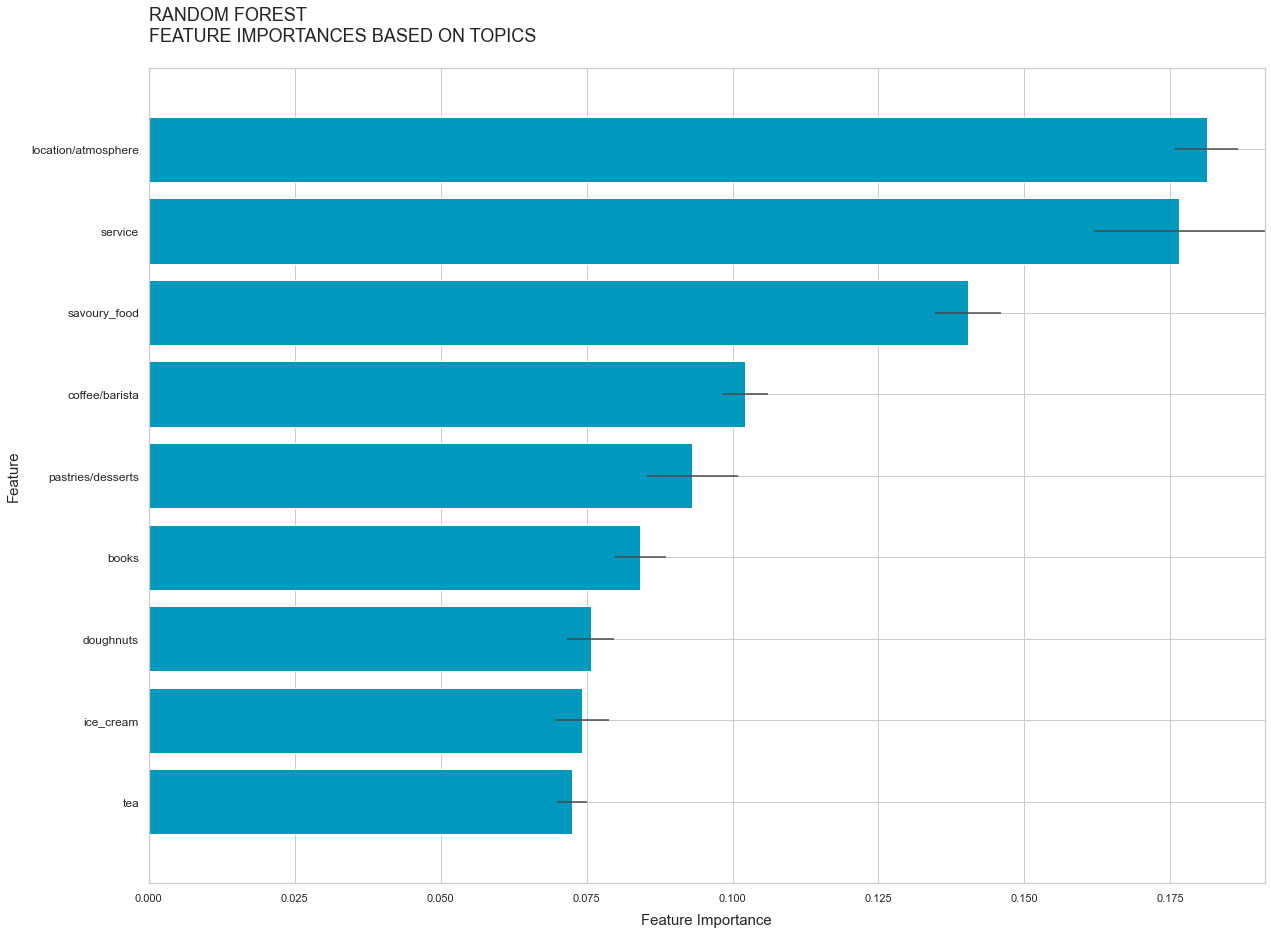

In [118]:
# Random Forest Validation | Plot feature importances

# compute feature importance and std
importances = rf_cl.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_cl.estimators_],
             axis=0)
indices = np.argsort(importances)

# plot the feature importances of the random forest
plt.figure(figsize=(20,15))
plt.margins(x=0)
sns.set_style("whitegrid")
plt.title("RANDOM FOREST\nFEATURE IMPORTANCES BASED ON TOPICS\n",fontsize = 18,loc = 'left')
ax = plt.barh(range(X_test.shape[1]), importances[indices],
       color = '#0399bf',ecolor ='#484848', xerr=std[indices], align="center")

# set labels
plt.xlabel('Feature Importance',labelpad = 10,fontsize = 15)
plt.ylabel('Feature',labelpad = 10,fontsize = 15)
plt.yticks(range(X_test.shape[1]), [features.columns[i] for i in indices],fontsize = 12)
plt.ylim([-1, X_test.shape[1]])
plt.savefig('/Users/valentinarizzati/Desktop/GitStuff/Projects/NLP-Yelp//images/importances.png')
plt.show();

----

In alignment with the output of the topic size analysis conducted up in this notebook, **location/atmosphere, service, savoury food and coffee/barista** are the most important elements in determining a positive sentiment review. Hence, both methodologies - the more crude topic size analysis and the more technical classification algorithm - give nearly equal results (with the addition of savoury food amongst the most important features in classification).

----